<a href="https://colab.research.google.com/github/silviolima07/PUC_residencia_tec_ml/blob/main/Aula20_Assincrona_AtividadePratica03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Grupo:
- Silvio Cesar de Lima - RA 23029232
- Vitor Pereira Andrade - RA 23029249
- Marcos Paulo Cassiano Pena - RA 23029256

# Aula 20 - Assíncrona - Atividade Prática 03

##  Implementação de modelos e verificação de eficiência da estratégia adotada em problemas de classificação considerando diferentes métodos de engenharia de features

Esta atividade corresponde à nossa terceira atividade **valorizada** do curso de *Machine Learning*.

### Instruções:

1 - Reunam-se em grupos de **no máximo 3 pessoas**;

2 - A entrega deve ser realizada via CANVAS através de um artigo no **formato PDF gerado a partir do *notebook***. Para tal fim, os grupos poderão utilizar o *Jupyter Notebook* ou o *Google Drive* para implementação do que foi solicitado.

3 - O período de disponibilidade para recebimento da atividade será de **25/09/23 às 17h, até 02/10/23, às 17h**.

4 - No cabeçalho do documento devem constar o **nome completo e o RA de TODOS os membros do grupo**.

#### Práticas a serem desenvolvidas:

1 - Substituição de valores inválidos;

2 - Verificação de eficiência considerando técnicas de normalização;

3 - Seleção de *Features*;

4 - Extração de *Features*;

5 - Validação Cruzada considerando o método *k-fold*.

### Parâmetros fixos a serem utilizados:

1 - Classificador ***Random Forest*** com `random_state = 0`;

2 - Função `train_test_split`:

     - Proporção de divisão de dados de treinamento e teste: 70% e 30%, respectivamente;
     - `random_state = 42`.
     


**Questão 1)** Considere o banco de dados `water_potability.csv`.

**a)** Verifique a existência de valores inválidos nos dados de entrada do *dataset* e, caso existam, observe os seguintes pontos:

    - Se a porcentagem de dados inválidos for maior do que 20%, exclua esta(s) coluna(s);
    - Se a porcentagem de dados inválidos for inferior a 20%, substitua os valores inválidos pelo valor imediatamente anterior, o método `bfill`.
    
**b)** Normalize os dados de entrada através do método `MinMaxScaler`.

**c)** Realize a tarefa de classificação utilizando ***Random Forest***, considerando 10 árvores na floresta.

**d)** Verifique a eficiência do método empregado utilizando a função `classification_report`.

**Questão 2)** Considerando os dados normalizados, e o modelo do classificador criado no exercício anterior, utilize o método de **seleção de features** **RFE** (*Recursive Feature Elimination*) para selecionar **3** *features* que farão parte da tarefa de classificação. Identifique quais colunas foram selecionadas. Analise os resultados por meio da função `classification_report`.

**Questão 3)** Considerando os dados normalizados e o modelo do classificador criado na **Questão 1)**, utilize a **Análise de Componentes Principais** para extrair as *features* que farão parte da tarefa de classificação. Considere utilizar **3** componentes principais e analise os resultados por meio da função `classification_report`.

**Questão 4)** Considerando as componentes principais extraídas na **Questão 3)**, utilize o método de **Validação Cruzada** por ***k-fold*** para verificar o número de àrvores adequado para a floresta na solução do problema. Considere variar o número de árvores entre 10 e 100, com passo de 10. Considere também `k = 10`, no método *k-fold*. Plote o resultado da acurácia do modelo de acordo com o número de árvores na floresta e realize a classificação considerando o melhor resultado alcançado na etapa de validação.

**Questão 5)** Explique os resultados obtidos nos exercícios anteriores.

## Resolução

### Import libs

In [247]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics  import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score # Cross Validation Function.
from sklearn.model_selection import KFold # KFold Class.

### Ler o dataset

In [248]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Questão 1

In [249]:
df = pd.read_csv("/content/drive/MyDrive/DATASETS/water_potability.csv")

In [250]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [251]:
print("Dataset Water_potablity tem", df.shape[0], "linhas e ", df.shape[1], ' colunas')

Dataset Water_potablity tem 3276 linhas e  10  colunas


### Percentual de dados ausentes por coluna

In [252]:
df.isnull().sum()/df.shape[0]

ph                 0.149878
Hardness           0.000000
Solids             0.000000
Chloramines        0.000000
Sulfate            0.238400
Conductivity       0.000000
Organic_carbon     0.000000
Trihalomethanes    0.049451
Turbidity          0.000000
Potability         0.000000
dtype: float64

### Filtrando as colunas com dados ausentes acima e abaixo de 20%.

In [253]:
print("Colunas com dados ausentes acima e abaixo de 20%\n")
acima= []
abaixo = []
cols = df.columns.tolist()
for col in cols:
  #print(col)
  valor = df[col].isnull().sum()/df.shape[0]
  if valor > 0.2:
    print("Acima\n", col, ":", valor)
    acima.append(col)
  elif valor < 0.2 and valor != 0:
    print("Abaixo\n", col, ":", valor)
    abaixo.append(col)


Colunas com dados ausentes acima e abaixo de 20%

Abaixo
 ph : 0.14987789987789987
Acima
 Sulfate : 0.23840048840048841
Abaixo
 Trihalomethanes : 0.04945054945054945


In [254]:
df.head(3)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0


### Remover colunas acima de 20% de dados ausentes.

In [255]:
df.drop(acima, axis=1, inplace=True)

In [256]:
df.shape

(3276, 9)

In [257]:
df.head(3)

,ph,Hardness,Solids,Chloramines,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,418.606213,16.868637,66.420093,3.055934,0


In [258]:
classes = df.Potability.unique().tolist()

### Colunas com dados inválidos for inferior a 20%, substitua os valores inválidos pelo valor imediatamente anterior, o método `bfill`.

In [259]:
abaixo

['ph', 'Trihalomethanes']

In [260]:
temp = df[abaixo]

In [261]:
temp.isnull().sum()

ph                 491
Trihalomethanes    162
dtype: int64

In [262]:
temp

,ph,Trihalomethanes
0,NaN,86.990970
1,3.716080,56.329076
2,8.099124,66.420093
3,8.316766,100.341674
4,9.092223,31.997993
...,...,...
3271,4.668102,66.687695
3272,7.808856,NaN
3273,9.419510,69.845400
3274,5.126763,77.488213


In [263]:
temp.loc[temp.ph.isnull()]

,ph,Trihalomethanes
0,NaN,86.990970
8,NaN,53.928846
13,NaN,76.509996
20,NaN,45.382815
22,NaN,59.855476
...,...,...
3224,NaN,85.428785
3229,NaN,72.911573
3231,NaN,103.912548
3245,NaN,56.038702


### O bfill irá copiar o valor existente numa coluna para a linha anterior da coluna caso esse linha tenha valor nulo (NaN). Isso é feito em linhas de cada coluna.

In [264]:
temp.bfill(inplace=True)

<ipython-input-264-ddd28e208944>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.bfill(inplace=True)


In [265]:
temp.loc[temp.ph.isnull()]

,ph,Trihalomethanes


In [266]:
temp.isnull().sum()

ph                 0
Trihalomethanes    0
dtype: int64

In [267]:
temp

,ph,Trihalomethanes
0,3.716080,86.990970
1,3.716080,56.329076
2,8.099124,66.420093
3,8.316766,100.341674
4,9.092223,31.997993
...,...,...
3271,4.668102,66.687695
3272,7.808856,69.845400
3273,9.419510,69.845400
3274,5.126763,77.488213


In [268]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               3276 non-null   float64
 1   Trihalomethanes  3276 non-null   float64
dtypes: float64(2)
memory usage: 51.3 KB


In [269]:
df[abaixo] = temp

### Checar se ainda existem dados ausentes.

In [270]:
df.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

### Dados de entrada X e dados de saida y.

In [271]:
df.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

In [272]:
df.shape

(3276, 9)

In [273]:
df.describe()

,ph,Hardness,Solids,Chloramines,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000
mean,7.068424,196.369496,22014.092526,7.122277,426.205111,14.284970,66.501175,3.966786,0.390110
std,1.599381,32.879761,8768.570828,1.583085,80.824064,3.308162,16.187650,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.087306,176.850538,15666.690297,6.127421,365.734414,12.065801,55.929700,3.439711,0.000000
50%,7.037422,196.967627,20927.833607,7.130299,421.884968,14.218338,66.697224,3.955028,0.000000
75%,8.062251,216.667456,27332.762127,8.114887,481.792304,16.557652,77.403013,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,753.342620,28.300000,124.000000,6.739000,1.000000


In [274]:
X = df.drop(['Potability'], axis=1)
y = df.Potability

### Proporção de divisão de dados de treinamento e teste:
- 70% e 30%, respectivamente
- random_state = 42

### Dividir o dataset em treino e teste antes de aplicar a normalização.

In [275]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state= 42)

In [276]:
X_train.head()

,ph,Hardness,Solids,Chloramines,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
2985,3.832917,188.445469,28791.614416,8.040356,422.234861,10.575690,63.235365,3.228379
1073,7.203439,168.445358,22826.484697,6.283250,437.370863,16.410654,64.505923,6.389161
3140,6.658742,242.827588,29298.074262,5.853840,463.115174,5.426650,82.244095,3.522586
2643,6.056818,211.765886,4440.277357,9.507303,316.921776,17.766397,53.541191,3.358061
2174,9.581189,223.296216,28292.780318,5.665431,398.479317,11.350768,44.574120,3.929178


In [277]:
X_test.head()

,ph,Hardness,Solids,Chloramines,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
2947,5.679330,183.521107,20461.252710,7.333212,356.369022,20.179029,67.019903,4.886634
2782,6.643159,188.913541,32873.820022,6.791509,336.561501,14.706810,67.844849,4.562198
1644,7.846058,224.058877,23264.109968,5.922367,387.971336,13.406737,43.075186,2.487969
70,7.160467,183.089310,6743.346066,3.803036,428.036344,9.799625,90.035374,3.884891
2045,6.615350,179.240661,26392.863612,9.309160,496.363562,12.786595,78.262369,4.453443


### Normalizar dados com MinMaxScaler

In [278]:
scaler = MinMaxScaler()

In [279]:
X_train_scaled = scaler.fit_transform(X_train)

In [280]:
X_train_scaled

array([[0.27377981, 0.46049122, 0.46386091, ..., 0.25926802, 0.47537151,
        0.33090165],
       [0.51453135, 0.38037276, 0.36526119, ..., 0.50312205, 0.48634123,
        0.93332328],
       [0.4756244 , 0.67834057, 0.47223236, ..., 0.04408003, 0.6394887 ,
        0.38697532],
       ...,
       [0.47359742, 0.45374375, 0.49935618, ..., 0.39467646, 0.67841861,
        0.38087663],
       [0.62736912, 0.57901528, 0.2554584 , ..., 0.50077611, 0.3360708 ,
        0.53021533],
       [0.47843956, 0.49991248, 0.56112371, ..., 0.32617631, 0.62610179,
        0.4318777 ]])

### RandomForest - considerando 10 árvores na floresta

In [281]:
rf = RandomForestClassifier(n_estimators = 10, random_state = 0)

In [282]:
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=10, random_state=0)

In [283]:
X_test_scaled = scaler.transform(X_test)

In [284]:
X_test_scaled.shape

(983, 8)

### Classification_report

In [285]:
pred = rf.predict(X_test_scaled)

In [286]:
print("Questão 1  RF\n\tClassification report\n\n",classification_report(y_test, pred))

Questão 1  RF
	Classification report

               precision    recall  f1-score   support

           0       0.66      0.81      0.72       617
           1       0.47      0.29      0.36       366

    accuracy                           0.61       983
   macro avg       0.56      0.55      0.54       983
weighted avg       0.59      0.61      0.59       983



In [287]:
temp_X_train1 = X_train_scaled
temp_y_train1 = y_train
temp_X_test1 = X_test_scaled
temp_y_test1 = y_test
pred1 = pred

## Questão 2

### Considerando os dados normalizados.
### Aplicar seleção de features RFE (Recursive Feature Elimination) para selecionar 3 features.

In [288]:
# Criando o seletor de features RFE
rfe = RFE(rf, n_features_to_select=3)

In [289]:
# Realizando a seleção de features sobre os dados de entrada normalizados. X_train_scaled
X_train_sc_selected = rfe.fit_transform(X_train_scaled, y_train)

In [290]:
X_train_sc_selected.shape

(2293, 3)

### Identificar as colunas selecionadas.

In [291]:
selected_features = rfe.support_
feature_ranking = rfe.ranking_

print("Features selecionadas:\n")
#for feature, selected in enumerate(selected_features):
#    if selected:
#        print(f"Feature {feature+1}")
# get all feature names
all_features = X_train.columns

# get selected feature names
selected_feature_names = all_features[selected_features]

# print the selected feature names
features = selected_feature_names.to_list()
print(features)

print("\nRanking das features:")
for feature, rank in enumerate(feature_ranking):
    print(f"Feature {feature+1}: {rank}")

Features selecionadas:

['ph', 'Hardness', 'Solids']

Ranking das features:
Feature 1: 1
Feature 2: 1
Feature 3: 1
Feature 4: 3
Feature 5: 6
Feature 6: 2
Feature 7: 5
Feature 8: 4


In [292]:
rf.fit(X_train_sc_selected, y_train)

RandomForestClassifier(n_estimators=10, random_state=0)

### Filtrar as colunas selecionadas em X_test_scaled

In [293]:
X_test_sc_selected = rfe.transform(X_test_scaled)

In [294]:
X_test_sc_selected.shape

(983, 3)

### Classification_report

In [295]:
pred = rf.predict(X_test_sc_selected)

In [296]:
print("Questão 2 RFE\n\tClassification report\n\n",classification_report(y_test, pred))

Questão 2 RFE
	Classification report

               precision    recall  f1-score   support

           0       0.66      0.82      0.73       617
           1       0.48      0.28      0.35       366

    accuracy                           0.62       983
   macro avg       0.57      0.55      0.54       983
weighted avg       0.59      0.62      0.59       983



In [297]:
temp_X_train2 = X_train_sc_selected
temp_y_train2 = y_train
temp_X_test2 = X_test_sc_selected
temp_y_test2 = y_test
pred2 = pred

### Teste usando Pipeline, apenas para aprendizado.

In [298]:
# create a pipeline object
pipeline = Pipeline([
    ('scaler', scaler),
    ('rfe', RFE(estimator=rf, n_features_to_select=3)),
    ('model', rf)
])

# fit the pipeline to the data
pipeline.fit(X_train_scaled, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('rfe',
                 RFE(estimator=RandomForestClassifier(n_estimators=10,
                                                      random_state=0),
                     n_features_to_select=3)),
                ('model',
                 RandomForestClassifier(n_estimators=10, random_state=0))])

In [299]:
X_test_sc_selected = rfe.transform(X_test_scaled)

In [300]:
pred = rf.predict(X_test_sc_selected)
#
print("Classification report\n\n",classification_report(y_test, pred))

Classification report

               precision    recall  f1-score   support

           0       0.66      0.82      0.73       617
           1       0.48      0.28      0.35       366

    accuracy                           0.62       983
   macro avg       0.57      0.55      0.54       983
weighted avg       0.59      0.62      0.59       983



## Questão 3

### Considerando os dados normalizados e o modelo do classificador criado
###  na Questão 1), utilize a Análise de Componentes Principais, extrair 3 componentes.

### PCA
### Reference:
- https://www.datacamp.com/tutorial/principal-component-analysis-in-python

In [301]:
# Criando o modelo através de um número de componentes principais
pca = PCA(n_components = 3)

### X_train_scaled vem da Questão 1

In [302]:
data = X_train_scaled
#
rf = RandomForestClassifier(n_estimators = 10, random_state = 0)

In [303]:
# Aplicando a PCA
P = pca.fit_transform(data)

print("Original:", data.shape)
print("PCA 85%:", P.shape)

#
X_train_pca = P

print("\nX_train_pca:", X_train_pca.shape)

Original: (2293, 8)
PCA 85%: (2293, 3)

X_train_pca: (2293, 3)


### Aplicar o PCA em X_test_scaled vindo da Questão 1

In [304]:
X_test_scaled.shape

(983, 8)

In [305]:
X_test_pca = pca.transform(X_test_scaled)

In [306]:
print("X_test com PCA:", X_test_pca.shape)

X_test com PCA: (983, 3)


In [307]:
X_train_pca.shape

(2293, 3)

In [308]:
X_test_pca.shape

(983, 3)

In [309]:
rf.fit(X_train_pca, y_train)

RandomForestClassifier(n_estimators=10, random_state=0)

### Classification_report

In [310]:
pred = rf.predict(X_test_pca)

In [311]:
print("Questão 3 PCA\n\tClassification report\n\n",classification_report(y_test, pred))

Questão 3 PCA
	Classification report

               precision    recall  f1-score   support

           0       0.62      0.76      0.68       617
           1       0.34      0.21      0.26       366

    accuracy                           0.56       983
   macro avg       0.48      0.49      0.47       983
weighted avg       0.52      0.56      0.53       983



In [312]:
temp_X_train3 = X_train_pca
temp_y_train3 = y_train
temp_X_test3 = X_test_pca
temp_y_test3 = y_test
pred3 = pred

In [313]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
var = pca.explained_variance_ratio_
print(round(np.sum(var),2))


Explained variation per principal component: [0.15573826 0.14382126 0.13766155]
0.44


## Questão 4

Considerando as componentes principais extraídas na Questão 3),
utilize o método de Validação Cruzada por k-fold para verificar o número de àrvores adequado para a floresta na solução do problema. Considere variar o número de árvores entre 10 e 100, com passo de 10. Considere também k = 10 , no método k-fold. Plote o resultado da acurácia do modelo de acordo com o número de árvores na floresta e realize a classificação considerando o melhor resultado alcançado na etapa de validação.

### Condições:
- modelo com random_state = 0
- numero de kfolds = 10
- KFold com shuffle = True e random_state = 0

In [314]:
X = X_train_pca
y = y_train

print('X dados\n', X.shape)
#
print('\ny dados\n',y.shape)

X dados
 (2293, 3)

y dados
 (2293,)


### Sem usar a lib KFold - apenas informando k = 10

In [315]:
# Importacao de biblioteca
from sklearn.model_selection import cross_val_score

# Vetor de possiveis valores de k: de 10 a 100
n_estimators_range = range(10,110, 10)

l_scores = []

k = 10

# Utilizando o loop para fazer a verificação dos resultados
for n in n_estimators_range:

    rf  = RandomForestClassifier(n_estimators = n,random_state=0)
    scores = cross_val_score(rf, X, y, cv = k, scoring = 'accuracy')
    scores = round(scores.mean(),2)
    l_scores.append(scores)
    print('n_estimators:', n, "--> Acuracia:", scores)


n_estimators: 10 --> Acuracia: 0.54
n_estimators: 20 --> Acuracia: 0.55
n_estimators: 30 --> Acuracia: 0.55
n_estimators: 40 --> Acuracia: 0.56
n_estimators: 50 --> Acuracia: 0.55
n_estimators: 60 --> Acuracia: 0.55
n_estimators: 70 --> Acuracia: 0.55
n_estimators: 80 --> Acuracia: 0.55
n_estimators: 90 --> Acuracia: 0.55
n_estimators: 100 --> Acuracia: 0.55


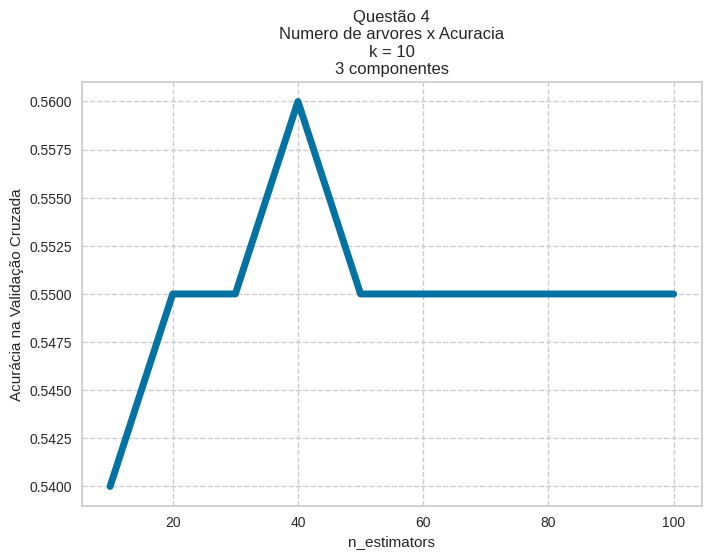

In [316]:
# plot to see clearly
plt.plot(n_estimators_range, l_scores, linewidth = 5.0)
plt.xlabel('n_estimators')
plt.ylabel('Acurácia na Validação Cruzada')
plt.grid(linestyle = "dashed")
plt.title("Questão 4\nNumero de arvores x Acuracia\nk = 10\n3 componentes")
plt.show()

### Usando a lib KFold com shuffle = True e random_state = 0

In [317]:
from sklearn.model_selection import KFold

l_scores4 = []
n_estimators_range = range(10,110, 10)

for arvores in n_estimators_range:
  modelo = RandomForestClassifier(n_estimators=arvores, random_state=0)
  kfold  = KFold(n_splits=10, shuffle=True, random_state = 0) # shuffle=True, Shuffle (embaralhar) the data.
  result = cross_val_score(modelo, X, y, cv = kfold.get_n_splits(), scoring = 'accuracy')
  acuracia = round(result.mean(),2)
  l_scores4.append(acuracia)
  print("kfold split = ",kfold.get_n_splits(), '--> n_estimators:', arvores, "--> Acuracia:", acuracia)



kfold split =  10 --> n_estimators: 10 --> Acuracia: 0.54
kfold split =  10 --> n_estimators: 20 --> Acuracia: 0.55
kfold split =  10 --> n_estimators: 30 --> Acuracia: 0.55
kfold split =  10 --> n_estimators: 40 --> Acuracia: 0.56
kfold split =  10 --> n_estimators: 50 --> Acuracia: 0.55
kfold split =  10 --> n_estimators: 60 --> Acuracia: 0.55
kfold split =  10 --> n_estimators: 70 --> Acuracia: 0.55
kfold split =  10 --> n_estimators: 80 --> Acuracia: 0.55
kfold split =  10 --> n_estimators: 90 --> Acuracia: 0.55
kfold split =  10 --> n_estimators: 100 --> Acuracia: 0.55


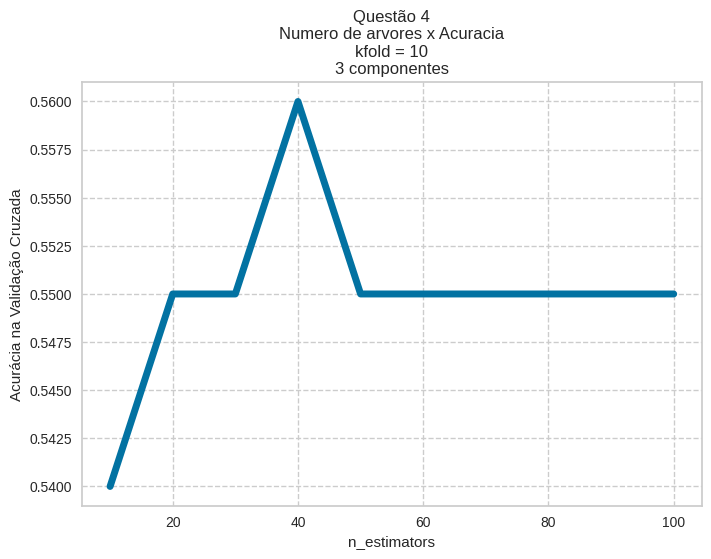

In [318]:
# plot to see clearly
plt.plot(n_estimators_range, l_scores4, linewidth = 5.0)
plt.xlabel('n_estimators')
plt.ylabel('Acurácia na Validação Cruzada')
plt.grid(linestyle = "dashed")
plt.title("Questão 4\nNumero de arvores x Acuracia\nkfold = 10\n3 componentes")
plt.show()


## Questão 5) Explique os resultados obtidos nos exercícios anteriores.

In [319]:
print("Questão 1  RF\n\tClassification report\n\n",classification_report(temp_y_test1, pred1))
#
print("Questão 2  RFE\n\tClassification report\n\n",classification_report(temp_y_test2, pred2))
#
print("Questão 3  PCA\n\tClassification report\n\n",classification_report(temp_y_test3, pred3))


Questão 1  RF
	Classification report

               precision    recall  f1-score   support

           0       0.66      0.81      0.72       617
           1       0.47      0.29      0.36       366

    accuracy                           0.61       983
   macro avg       0.56      0.55      0.54       983
weighted avg       0.59      0.61      0.59       983

Questão 2  RFE
	Classification report

               precision    recall  f1-score   support

           0       0.66      0.82      0.73       617
           1       0.48      0.28      0.35       366

    accuracy                           0.62       983
   macro avg       0.57      0.55      0.54       983
weighted avg       0.59      0.62      0.59       983

Questão 3  PCA
	Classification report

               precision    recall  f1-score   support

           0       0.62      0.76      0.68       617
           1       0.34      0.21      0.26       366

    accuracy                           0.56       983
   macro 

In [320]:
from yellowbrick.classifier import ClassificationReport

				Questão 1 RF


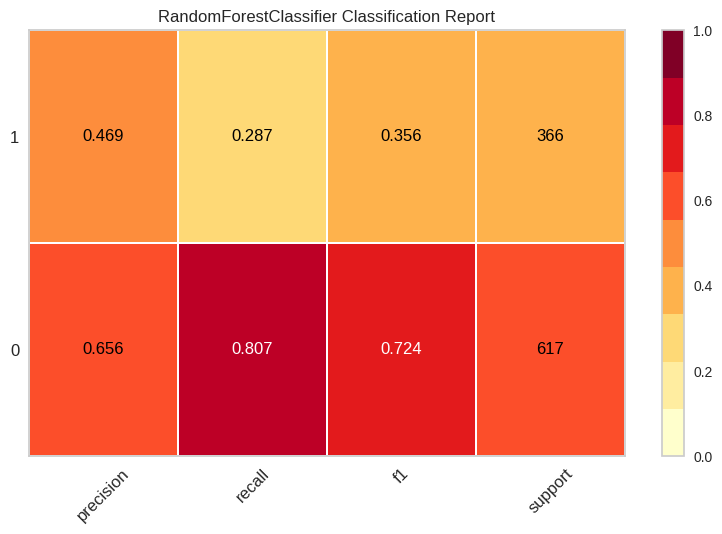

<Axes: title={'center': 'RandomForestClassifier Classification Report'}>

In [321]:
rf = RandomForestClassifier(n_estimators = 10, random_state = 0)
visualizer = ClassificationReport(rf, classes=classes, support=True)
print("\t\t\t\tQuestão 1 RF")
visualizer.fit(temp_X_train1, temp_y_train1)        # Fit the visualizer and the model
visualizer.score(temp_X_test1, temp_y_test1)        # Evaluate the model on the test data
visualizer.show()                     # Finalize and show the figure


				Questão 2 RFE


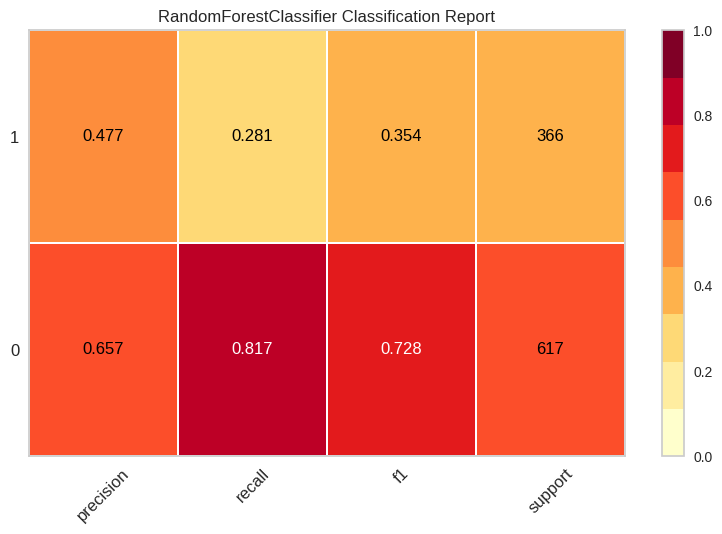

In [322]:

rf = RandomForestClassifier(n_estimators = 10, random_state = 0)
rf.fit(temp_X_train2, y_train)
visualizer = ClassificationReport(rf, classes=classes, support=True)
print("\t\t\t\tQuestão 2 RFE")
visualizer.fit(temp_X_train2, temp_y_train2)        # Fit the visualizer and the model
visualizer.score(temp_X_test2, temp_y_test2)        # Evaluate the model on the test data
visualizer.show();                      # Finalize and show the figure

				Questão 3 PCA


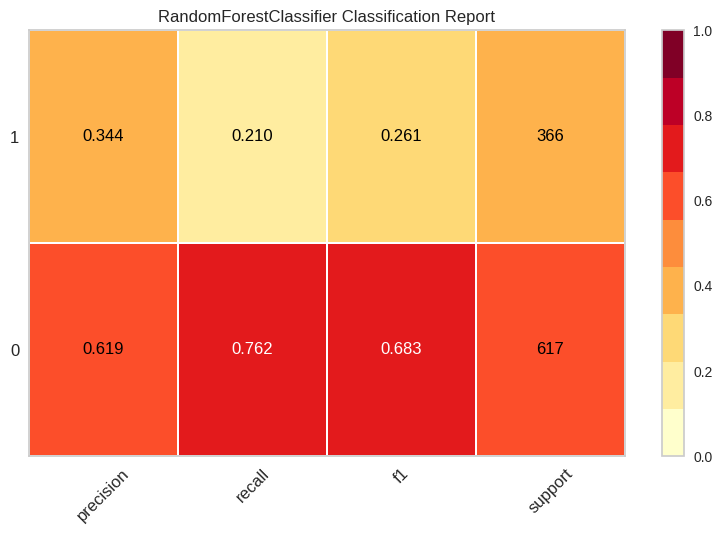

In [323]:

rf = RandomForestClassifier(n_estimators = 10, random_state = 0)
rf.fit(temp_X_train3, temp_y_train3)
visualizer = ClassificationReport(rf, classes=classes, support=True)
print("\t\t\t\tQuestão 3 PCA")
visualizer.fit(temp_X_train3, temp_y_train3)        # Fit the visualizer and the model
visualizer.score(temp_X_test3, temp_y_test3)        # Evaluate the model on the test data
visualizer.show();

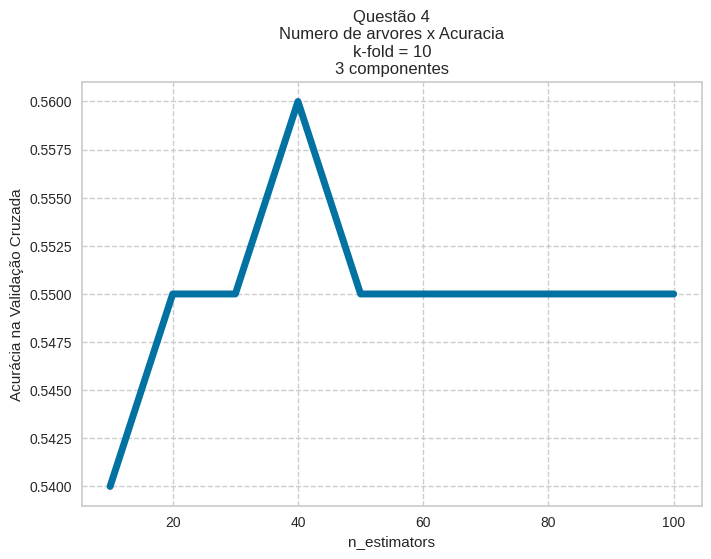

In [324]:
# plot to see clearly
plt.plot(n_estimators_range, l_scores4, linewidth = 5.0)
plt.xlabel('n_estimators')
plt.ylabel('Acurácia na Validação Cruzada')
plt.grid(linestyle = "dashed")
plt.title("Questão 4\nNumero de arvores x Acuracia\nk-fold = 10\n3 componentes")
plt.show()

## Análise
### O dataset original possue 3276 linhas e  10  colunas.
### Uma coluna apresentou mais de 20% de dados ausentes e por isso foi removido.
### Duas colunas apresentaram menos de 20% de dados ausentes e por isso foi aplicado o bfill, que preencheu as linhas com dados missing com a informaçao da linha adiante dela. Por exemplo se a linha com index 0 tem NaN, o bfill irá trazer a informação da linha do index 1 para a linha de index 0.
### O dataset ficou 9 colunas  e 3276 linhas.
### O dataset foi divido em treino e teste, usando test_size igual a 0.3 e random_state = 42.
### O classificador foi o randomforestclassifier com 10 de n_estimator e random_state igual a 0.
### Foi feita normalização através do MinMaxScaler nos dados de treinamento, X_train e X_test. O scaler foi treinado com X_train com fit_transform e aplicado sobre X_test com transform.
## Questão1
### Com os dados de entrada normalizados foi feito o treinamento do modelo e a previsão com dados de teste. O relatório das métricas de classificação do modelo apresentou uma acurácia de 61%, utilizando 8 colunas de features para identificar uma classe.
## Questão 2
### Foram usados os dados de treinamento normalizados da Questão 1 e selecionados 3 features (['ph', 'Hardness', 'Solids']) aplicando RFE. Estas features apresentaram maior importância em relaçao a classe target.
### O modelo randomforestclassifier foi treinado usando as features e o conjunto de test, X_test foi transformado também pela aplicação do RFE treinado para filtrar 3 features.
## A acurácia obtida foi de 62%, usando 3 features selecionadas pelo RFE.
## Questão 3
### Considerando os dados normalizados e o modelo do classificador criado na Questão 1), utilizei a PCA - Análise de Componentes Principais, para extrair 3 componentes. De 8 features no dataset de treino foram extraidos 3 componentes. O mesmo foi feito nos dados de teste.
### O modelo randomforestclassifier foi treinado com o novo conjunto de dados e a performance avaliada. Foi encontrada uma acurácia de 56%, usando 3 componentes representando as 8 features iniciais.
## Questão 4
### Foram feitos diversos testes, usando uma lista de valores para o número de estimadores usados pelo modelo classificaor. Também foi usado a lib KFold para gerar um valor de folds fixo pensando na reprodutibilidade da experiencia.
### Os valores de acurácia não foram influência e se manteve os mesmos valores.
### A maior acurácia encontrada foi 56% com n_estinmators igual a 40.
## Geral
### A medida que diminuímos o número de features com RFE, o modelo apresentou uma melhora de 1%, de 61% para 62%, usando as 3 features mais importantes em relação a classe potabilidade.
### Quando reduzimos a dimensão de 8 features para 3 componentes houve uma redução na acurácia encontrada, pois os componentes não representaram plenamente as 8 features existentes originais.
### Os 3 componentes gerados pelo PCA representam apenas 44% das features originais.
### Apenas a quantidade de arvores definidas pelo parametro n_estimators não define a performance do modelo, outros fatores afetam o resultado atingido. É preciso testar diversos valores para definir o valor ideal. Nesse caso, com 40 arvores o modelo atingiu a maior acurácia, o que na pratica significa menos processamento e consumo de recursos, bem como tempo de processamento.






